In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 320

ng =10

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 1000

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 20

data w_diffuse
     &     /1.6 , 1.8 , 1.8 , 1.8,
     &     1.7 , 1.6 , 1.4 , 1.4,
     &     1.7 , 1.8/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6 , 0.6/

atmosphere_profiles/trp75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

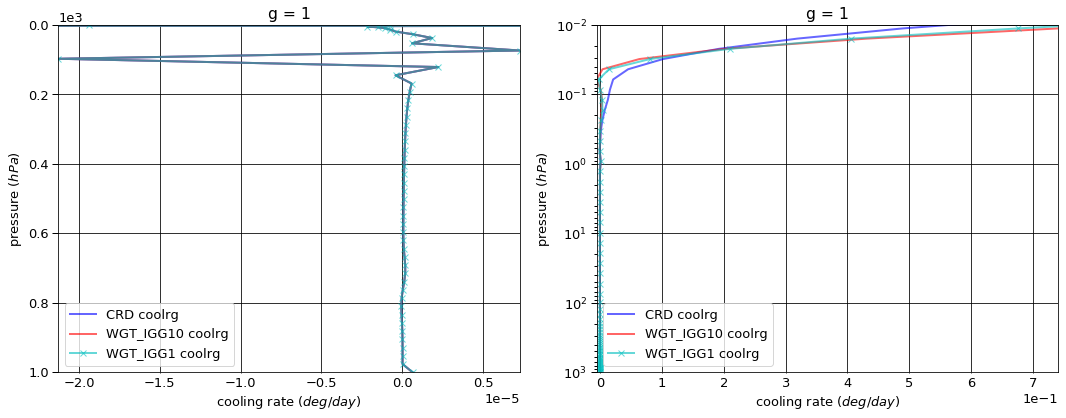

# Figure: cooling rate g-group 2

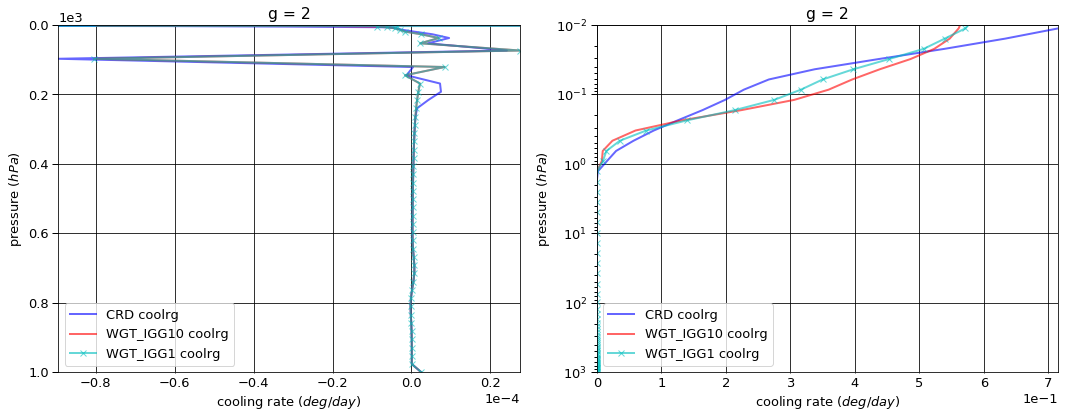

# Figure: cooling rate g-group 3

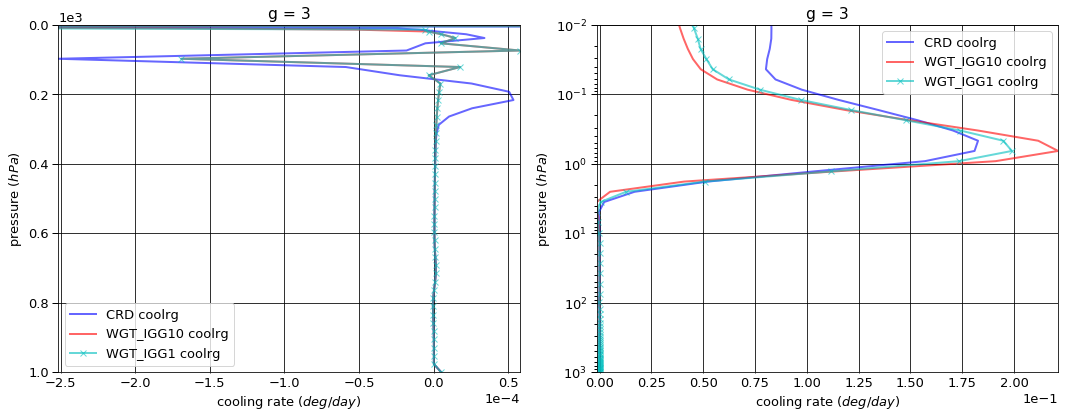

# Figure: cooling rate g-group 4

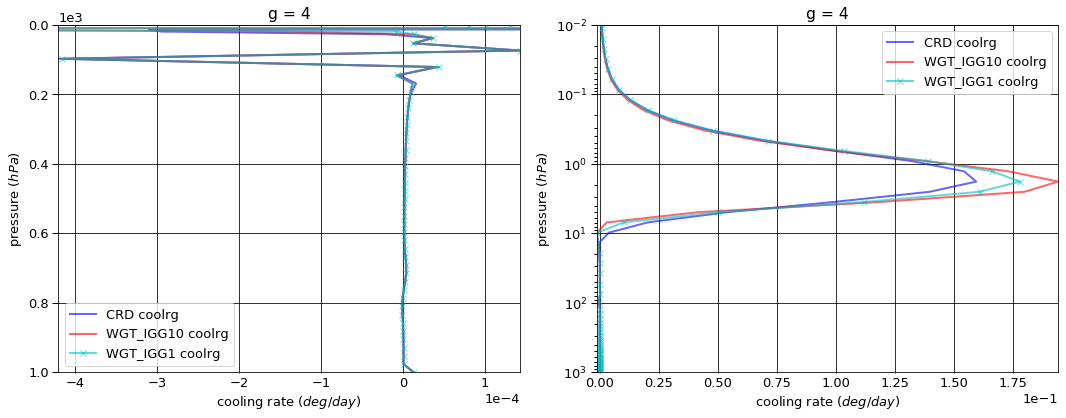

# Figure: cooling rate g-group 5

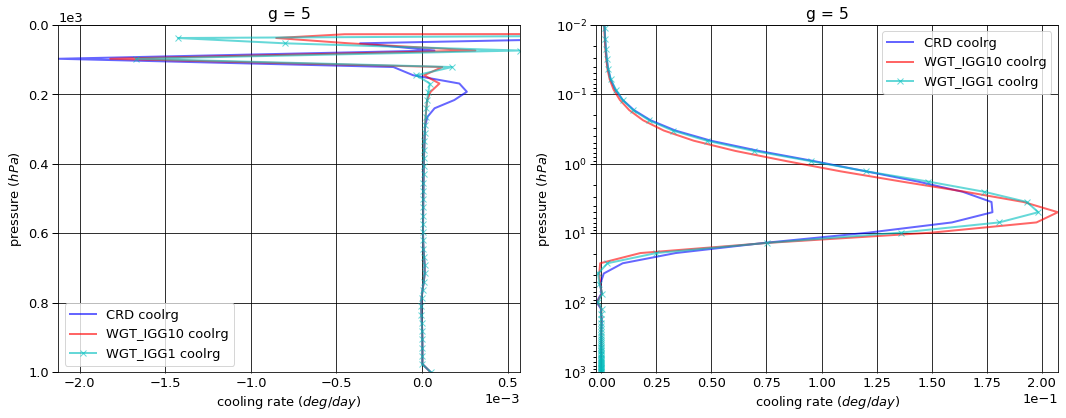

# Figure: cooling rate g-group 6

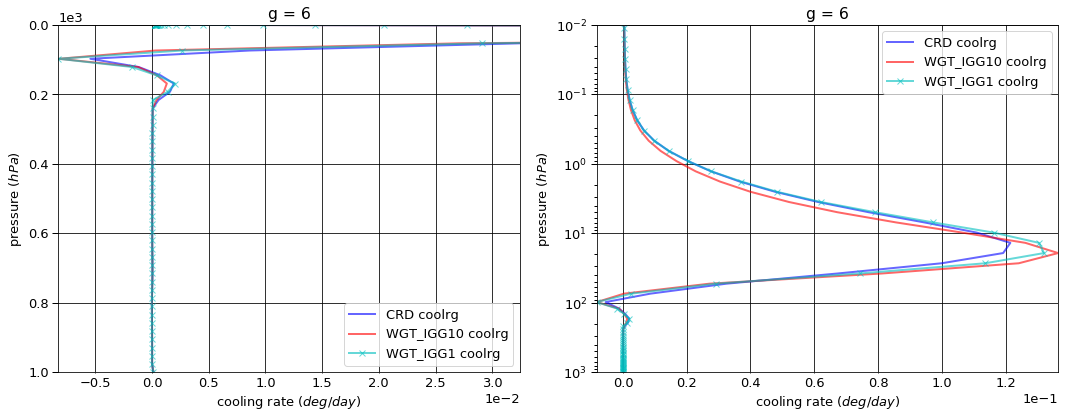

# Figure: cooling rate g-group 7

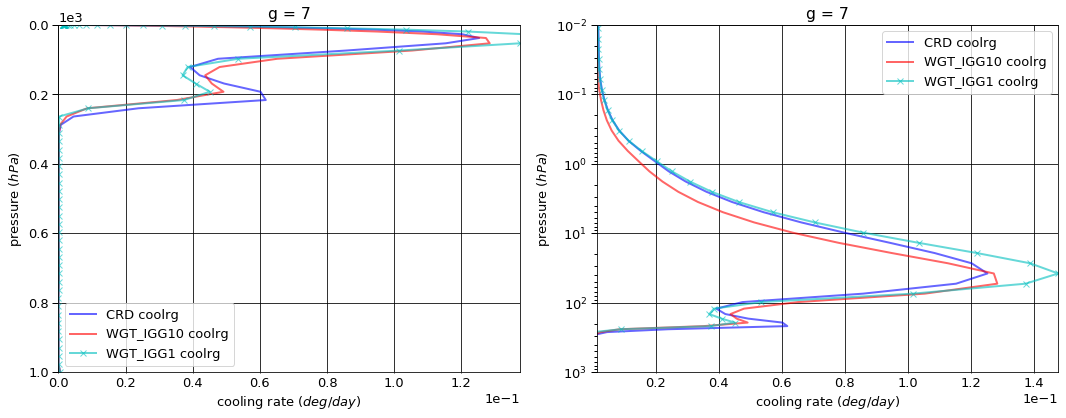

# Figure: cooling rate g-group 8

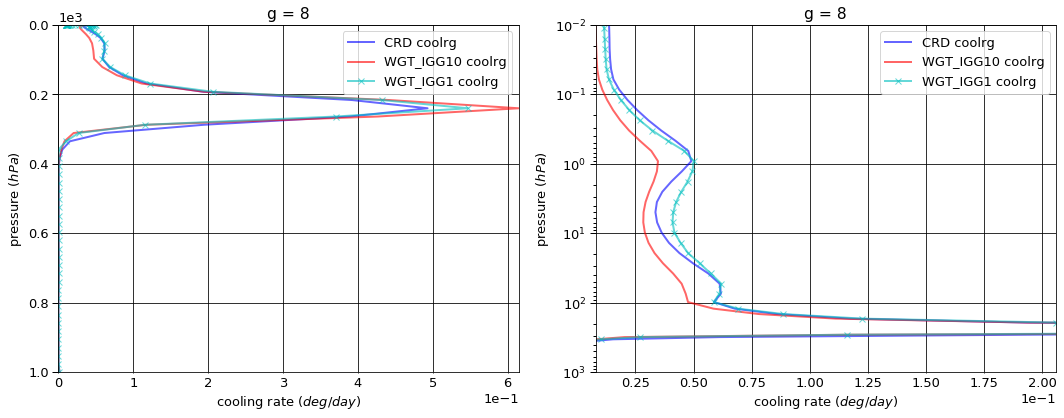

# Figure: cooling rate g-group 9

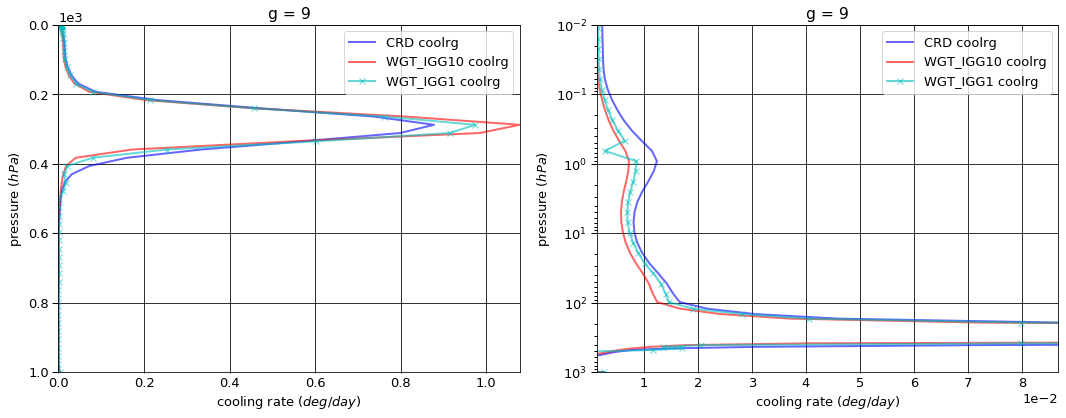

# Figure: cooling rate g-group 10

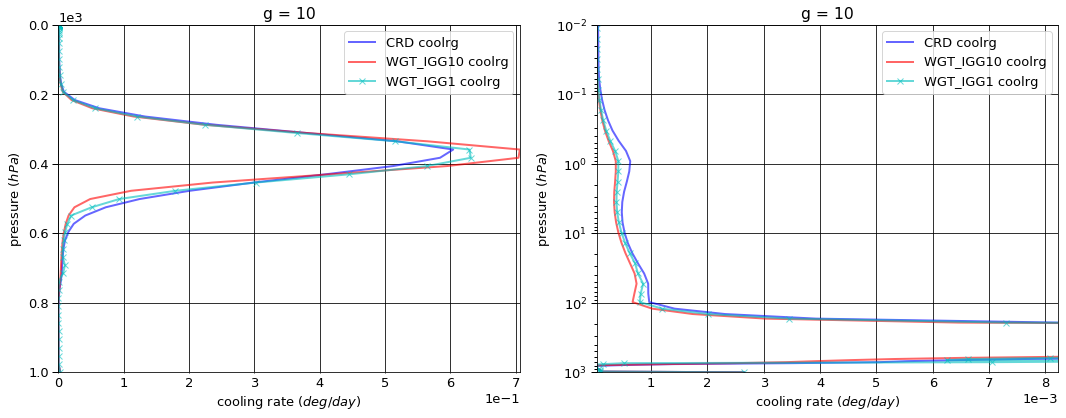

# Figure: cooling rate g-group total

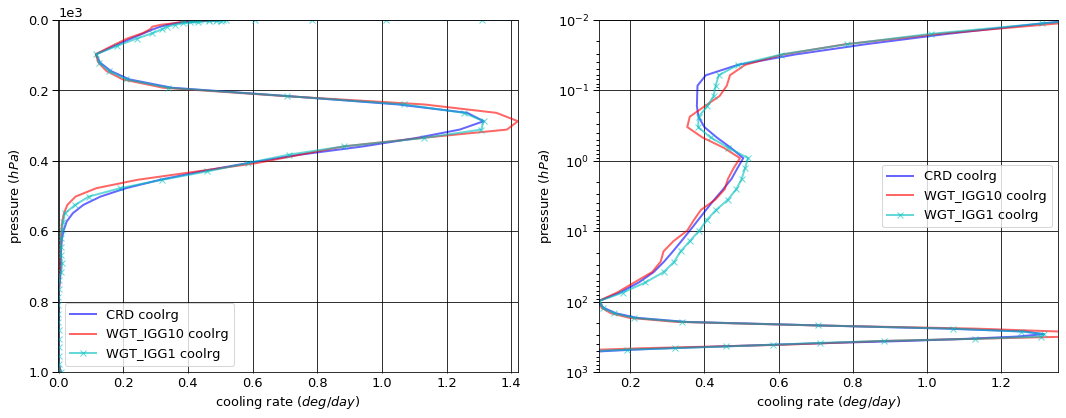

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.002802   0.000000  -0.002802
   1013.0   76     -0.004954   0.004952  -0.000002
2  0.0      1      -0.011461   0.000000  -0.011461
   1013.0   76     -0.018250   0.018243  -0.000007
3  0.0      1      -0.030466   0.000000  -0.030466
   1013.0   76     -0.039206   0.039191  -0.000014
4  0.0      1      -0.074060   0.000000  -0.074060
   1013.0   76     -0.096568   0.096533  -0.000035
5  0.0      1      -0.265514   0.000000  -0.265514
   1013.0   76     -0.386986   0.386845  -0.000141
6  0.0      1      -0.558875   0.000000  -0.558875
   1013.0   76     -0.935684   0.935344  -0.000339
7  0.0      1      -1.945213   0.000000  -1.945213
   1013.0   76     -3.558978   3.557684  -0.001294
8  0.0      1      -6.407106   0.000000  -6.407106
   1013.0   76    -10.705028  10.701117  -0.003911
9  0.0      1     -12.890676   0.000000 -12.890676
   1013.0   76    -19.619591  19.612243  -0.007348
10 0.0      1     -12.146825   0.000000 -12.146825
   1013.0   76    -17.499139  17.491793  -0.007345


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.002782   0.000000  -0.002782
   1013.0   76     -0.004954   0.004952  -0.000002
2  0.0      1      -0.011098   0.000000  -0.011098
   1013.0   76     -0.018250   0.018243  -0.000007
3  0.0      1      -0.030818   0.000000  -0.030818
   1013.0   76     -0.039206   0.039191  -0.000014
4  0.0      1      -0.075178   0.000000  -0.075178
   1013.0   76     -0.096568   0.096533  -0.000035
5  0.0      1      -0.268692   0.000000  -0.268692
   1013.0   76     -0.386986   0.386845  -0.000141
6  0.0      1      -0.565112   0.000000  -0.565112
   1013.0   76     -0.935684   0.935344  -0.000339
7  0.0      1      -1.900595   0.000000  -1.900595
   1013.0   76     -3.558978   3.557684  -0.001294
8  0.0      1      -6.408093   0.000000  -6.408093
   1013.0   76    -10.705028  10.701117  -0.003911
9  0.0      1     -12.819531   0.000000 -12.819531
   1013.0   76    -19.619591  19.612243  -0.007348
10 0.0      1     -12.059117   0.000000 -12.059117
   1013.0   76    -17.499139  17.491802  -0.007336


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.002782   0.000000  -0.002782
   1013.0   76     -0.004954   0.004952  -0.000002
2  0.0      1      -0.011242   0.000000  -0.011242
   1013.0   76     -0.018250   0.018243  -0.000007
3  0.0      1      -0.030743   0.000000  -0.030743
   1013.0   76     -0.039206   0.039191  -0.000014
4  0.0      1      -0.074766   0.000000  -0.074766
   1013.0   76     -0.096568   0.096533  -0.000035
5  0.0      1      -0.268129   0.000000  -0.268129
   1013.0   76     -0.386986   0.386845  -0.000141
6  0.0      1      -0.565950   0.000000  -0.565950
   1013.0   76     -0.935684   0.935344  -0.000339
7  0.0      1      -1.919647   0.000000  -1.919647
   1013.0   76     -3.558978   3.557684  -0.001294
8  0.0      1      -6.346647   0.000000  -6.346647
   1013.0   76    -10.705028  10.701117  -0.003911
9  0.0      1     -12.833823   0.000000 -12.833823
   1013.0   76    -19.619591  19.612243  -0.007348
10 0.0      1     -12.124099   0.000000 -12.124099
   1013.0   76    -17.499139  17.491802  -0.007336


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      2.000760e-05  0.000000e+00  2.000760e-05
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2  0.0      1      3.633240e-04  0.000000e+00  3.633240e-04
   1013.0   76     0.000000e+00  0.000000e+00 -8.470329e-22
3  0.0      1     -3.525950e-04  0.000000e+00 -3.525950e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1     -1.118112e-03  0.000000e+00 -1.118112e-03
   1013.0   76    -1.387779e-17  1.387779e-17  0.000000e+00
5  0.0      1     -3.177400e-03  0.000000e+00 -3.177400e-03
   1013.0   76     0.000000e+00  0.000000e+00  2.710505e-20
6  0.0      1     -6.236950e-03  0.000000e+00 -6.236950e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      4.461860e-02  0.000000e+00  4.461860e-02
   1013.0   76    -4.440892e-16  0.000000e+00  0.000000e+00
8  0.0      1     -9.875000e-04  0.000000e+00 -9.875000e-04
   1013.0   76     0.000000e+00  0.000000e+00 -8.673617e-19
9  0.0      1      7.114500e-02  0.000000e+00  7.114500e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
10 0.0      1      8.770800e-02  0.000000e+00  8.770800e-02
   1013.0   76     0.000000e+00  9.000000e-06  9.031100e-06


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      2.035310e-05  0.000000e+00  2.035310e-05
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2  0.0      1      2.196150e-04  0.000000e+00  2.196150e-04
   1013.0   76     0.000000e+00  0.000000e+00 -8.470329e-22
3  0.0      1     -2.773910e-04  0.000000e+00 -2.773910e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1     -7.063020e-04  0.000000e+00 -7.063020e-04
   1013.0   76    -1.387779e-17  1.387779e-17  0.000000e+00
5  0.0      1     -2.614480e-03  0.000000e+00 -2.614480e-03
   1013.0   76     0.000000e+00  0.000000e+00  2.710505e-20
6  0.0      1     -7.075640e-03  0.000000e+00 -7.075640e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      2.556590e-02  0.000000e+00  2.556590e-02
   1013.0   76    -4.440892e-16  0.000000e+00  0.000000e+00
8  0.0      1      6.045900e-02  0.000000e+00  6.045900e-02
   1013.0   76     0.000000e+00  0.000000e+00 -8.673617e-19
9  0.0      1      5.685300e-02  0.000000e+00  5.685300e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
10 0.0      1      2.272600e-02  0.000000e+00  2.272600e-02
   1013.0   76     0.000000e+00  9.000000e-06  9.031100e-06

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      4.414434e+00
   1001.112500 75     6.424913e-07
2  0.000312    1      9.826818e-01
   1001.112500 75     2.505971e-06
3  0.000312    1      7.426742e-02
   1001.112500 75     5.145061e-06
4  0.000312    1      5.885852e-05
   1001.112500 75     1.260667e-05
5  0.000312    1      7.972069e-04
   1001.112500 75     5.080924e-05
6  0.000312    1      2.788924e-04
   1001.112500 75     1.221553e-04
7  0.000312    1      1.439378e-03
   1001.112500 75     4.660655e-04
8  0.000312    1      1.179110e-02
   1001.112500 75     1.408341e-03
9  0.000312    1      1.925820e-03
   1001.112500 75     2.646107e-03
10 0.000312    1      4.506926e-05
   1001.112500 75     2.645125e-03


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      2.609616e+00
   1001.112500 75     6.424913e-07
2  0.000312    1      5.298847e-01
   1001.112500 75     2.505971e-06
3  0.000312    1      2.979331e-02
   1001.112500 75     5.145061e-06
4  0.000312    1      4.707634e-05
   1001.112500 75     1.260667e-05
5  0.000312    1      7.814836e-04
   1001.112500 75     5.080924e-05
6  0.000312    1      2.273345e-04
   1001.112500 75     1.221553e-04
7  0.000312    1      9.861131e-04
   1001.112500 75     4.660655e-04
8  0.000312    1      6.765570e-03
   1001.112500 75     1.408341e-03
9  0.000312    1      1.076185e-03
   1001.112500 75     2.646107e-03
10 0.000312    1      2.426535e-05
   1001.112500 75     2.640932e-03


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      3.075909e+00
   1001.112500 75     6.424913e-07
2  0.000312    1      5.958813e-01
   1001.112500 75     2.505971e-06
3  0.000312    1      3.556153e-02
   1001.112500 75     5.145061e-06
4  0.000312    1      5.131289e-05
   1001.112500 75     1.260667e-05
5  0.000312    1      8.724159e-04
   1001.112500 75     5.080924e-05
6  0.000312    1      2.703483e-04
   1001.112500 75     1.221553e-04
7  0.000312    1      1.352280e-03
   1001.112500 75     4.660655e-04
8  0.000312    1      9.977085e-03
   1001.112500 75     1.408341e-03
9  0.000312    1      1.314295e-03
   1001.112500 75     2.646107e-03
10 0.000312    1      2.814984e-05
   1001.112500 75     2.640932e-03


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.804818e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -4.527971e-01
   1001.112500 75     0.000000e+00
3  0.000312    1     -4.447411e-02
   1001.112500 75     8.470329e-22
4  0.000312    1     -1.178218e-05
   1001.112500 75    -1.694066e-21
5  0.000312    1     -1.572337e-05
   1001.112500 75     0.000000e+00
6  0.000312    1     -5.155791e-05
   1001.112500 75     0.000000e+00
7  0.000312    1     -4.532645e-04
   1001.112500 75     5.421011e-20
8  0.000312    1     -5.025534e-03
   1001.112500 75     0.000000e+00
9  0.000312    1     -8.496350e-04
   1001.112500 75     0.000000e+00
10 0.000312    1     -2.080391e-05
   1001.112500 75    -4.193700e-06


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.338525e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -3.868004e-01
   1001.112500 75     0.000000e+00
3  0.000312    1     -3.870589e-02
   1001.112500 75     8.470329e-22
4  0.000312    1     -7.545637e-06
   1001.112500 75    -1.694066e-21
5  0.000312    1      7.520899e-05
   1001.112500 75     0.000000e+00
6  0.000312    1     -8.544120e-06
   1001.112500 75     0.000000e+00
7  0.000312    1     -8.709790e-05
   1001.112500 75     5.421011e-20
8  0.000312    1     -1.814019e-03
   1001.112500 75     0.000000e+00
9  0.000312    1     -6.115254e-04
   1001.112500 75     0.000000e+00
10 0.000312    1     -1.691941e-05
   1001.112500 75    -4.193700e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.332999,0.000000,-34.332999
1013.0,76,-52.864385,52.843947,-0.020437



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.141016,0.000000,-34.141016
1013.0,76,-52.864385,52.843956,-0.020428



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.177829,0.000000,-34.177829
1013.0,76,-52.864385,52.843956,-0.020428



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.191982,0.000000,0.191982
1013.0,76,0.000000,0.000009,0.000009



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.15517,0.000000,0.155170
1013.0,76,0.00000,0.000009,0.000009


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,5.487719
1001.112500,75,0.007360



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,3.179202
1001.112500,75,0.007355



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,3.721218
1001.112500,75,0.007355



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.308517
1001.112500,75,-0.000004



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.766501
1001.112500,75,-0.000004


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000109,0.000096
2,0.000341,0.000347
3,0.000884,0.000756
4,0.002078,0.001866
5,0.008837,0.007466
6,0.020303,0.018082
7,0.082453,0.068733
8,0.239828,0.206380
9,0.400194,0.375109


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.441550e-16
2,3.621082e-17
3,3.809979e-18
4,9.034937e-18
5,9.970460e-19
6,9.178721e-19
7,1.059911e-19
8,1.223930e-20
9,1.413330e-21


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.441550e-16,NaN,0.000109,0.000096,0.000109,0.000096,1.0
2,3.621082e-17,0.105217,0.000341,0.000347,0.000450,0.000443,1.0
3,3.809979e-18,0.105217,0.000884,0.000756,0.001334,0.001199,1.0
4,9.034937e-18,2.371387,0.002078,0.001866,0.003413,0.003065,30.0
5,9.970460e-19,0.110355,0.008837,0.007466,0.012250,0.010531,30.0
6,9.178721e-19,0.920592,0.020303,0.018082,0.032553,0.028613,300.0
7,1.059911e-19,0.115475,0.082453,0.068733,0.115006,0.097346,300.0
8,1.223930e-20,0.115475,0.239828,0.206380,0.354834,0.303726,300.0
9,1.413330e-21,0.115475,0.400194,0.375109,0.755028,0.678835,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [27]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     1.176125e-15  4.878732e-16   2.410719  4.804438e-02
      2  0.000312     6.217367e-17  2.981654e-17   2.085208  2.734779e-03
      3  0.000312     2.615107e-18  1.064126e-18   2.457515  1.058258e-04
      4  0.000312     9.634735e-22  9.383939e-22   1.026726  6.545130e-08
      5  0.000312     3.876028e-21  3.031113e-21   1.278748  2.272719e-07
      6  0.000312     4.163428e-22  3.039375e-22   1.369830  2.336379e-08
      7  0.000312     5.619438e-22  1.204771e-22   4.664320  2.666418e-08
      8  0.000312     1.639532e-21  5.143595e-23  31.875211  6.949050e-08
      9  0.000312     1.380739e-22  5.096905e-24  27.089756  5.873353e-09
      10 0.000312     4.672703e-24  3.819748e-25  12.233013  2.045643e-10
2     1  0.000750     1.175810e-15  4.887044e-16   2.405975  1.936522e-02
      2  0.000750     6.239711e-17  2.992555e-17   2.085078  1.105527e-03
      3  0.000750     2.629915e-18  1.071882e-18   2.453550  4.290035e-05
      4  0.000750     1.471354e-21  1.446098e-21   1.017465  4.051418e-08
      5  0.000750     3.974894e-21  3.116098e-21   1.275600  9.402669e-08
      6  0.000750     4.222040e-22  3.095097e-22   1.364106  9.568338e-09
      7  0.000750     5.643557e-22  1.215793e-22   4.641872  1.079260e-08
      8  0.000750     1.644438e-21  5.169452e-23  31.810675  2.807477e-08
      9  0.000750     1.386036e-22  5.125095e-24  27.044114  2.374881e-09
      10 0.000750     4.696648e-24  3.843289e-25  12.220386  8.282241e-11
3     1  0.001052     1.175340e-15  4.902337e-16   2.397510  2.719383e-02
      2  0.001052     6.282804e-17  3.011233e-17   2.086456  1.560539e-03
      3  0.001052     2.655773e-18  1.082158e-18   2.454144  6.074720e-05
      4  0.001052     1.826097e-21  1.800826e-21   1.014033  7.068117e-08
      5  0.001052     4.096512e-21  3.209665e-21   1.276305  1.358476e-07
      6  0.001052     4.273548e-22  3.140498e-22   1.360787  1.360311e-08
      7  0.001052     5.681956e-22  1.227218e-22   4.629949  1.524329e-08
      8  0.001052     1.654364e-21  5.202725e-23  31.798025  3.960964e-08
      9  0.001052     1.396752e-22  5.164759e-24  27.043888  3.356247e-09
      10 0.001052     4.744426e-24  3.878415e-25  12.232901  1.173243e-10
4     1  0.001476     1.174826e-15  4.918097e-16   2.388782  3.820205e-02
      2  0.001476     6.327067e-17  3.030877e-17   2.087537  2.204088e-03
      3  0.001476     2.683117e-18  1.093686e-18   2.453280  8.611399e-05
      4  0.001476     2.321338e-21  2.296037e-21   1.011019  1.263118e-07
      5  0.001476     4.237723e-21  3.321199e-21   1.275962  1.971833e-07
      6  0.001476     4.339422e-22  3.200152e-22   1.356005  1.942102e-08
      7  0.001476     5.723580e-22  1.241040e-22   4.611923  2.155195e-08
      8  0.001476     1.664592e-21  5.240362e-23  31.764824  5.591278e-08
      9  0.001476     1.407782e-22  5.208567e-24  27.028207  4.745703e-09
      10 0.001476     4.794115e-24  3.916717e-25  12.240136  1.663121e-10
5     1  0.002070     1.174261e-15  4.934246e-16   2.379819  5.365559e-02
      2  0.002070     6.372106e-17  3.051536e-17   2.088163  3.112939e-03
      3  0.002070     2.711986e-18  1.106813e-18   2.450266  1.221551e-04
      4  0.002070     3.013469e-21  2.988106e-21   1.008488  2.303891e-07
      5  0.002070     4.404270e-21  3.456684e-21   1.274131  2.877031e-07
      6  0.002070     4.425089e-22  3.279586e-22   1.349283  2.786494e-08
      7  0.002070     5.768912e-22  1.258111e-22   4.585377  3.049017e-08
      8  0.002070     1.674998e-21  5.283621e-23  31.701716  7.891605e-08
      9  0.002070     1.418996e-22  5.257539e-24  26.989746  6.709514e-09
      10 0.002070     4.845215e-24  3.958895e-25  12.238807  2.357548e-10
6     1  0.002904     1.173626e-15  4.950943e-16   2.370511  7.537026e-02
      2  0.002904     6.418158e-17  3.073598e-17   2.088158  4.398200e-03
      3  0.002904     2.742879e

# Histogram of wavenumbers in g-group 1

In [28]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [29]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
